In [8]:
import os
import yaml
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path

import torchvision.models as model_zoo

from scheduler import extract_layer_info

In [19]:
arch = 'designs/eyeriss_like/ver0_test'
workload = 'alexnet'

base_dir = Path(os.getcwd())
timeloop_dir = arch
top_dir = 'workloads'
sub_dir = '{}_batch{}'.format(workload, 1)

if workload == 'alexnet':
    net = model_zoo.alexnet(pretrained=False)
    layers_exclude_from_search = [6, 7, 8]
elif workload == 'resnet18':
    net = model_zoo.resnet18(pretrained=False)
    layers_exclude_from_search = []
elif workload == 'mobilenet_v2':
    net = model_zoo.mobilenet_v2(pretrained=False)
    layers_exclude_from_search = []

input_size = (3, 224, 224)
batch_size = 1

n_layers, unique_layers, layer_info, layer_info_ignore_interlayer = extract_layer_info(net, input_size, base_dir, top_dir, sub_dir)

scheduling_methods = ['crypt-tile-single', 'crypt-opt-single', 'crypt-opt-cross']
cost_dicts = []
rehash_cost_dicts = []
for scheduler in scheduling_methods:
    if scheduler == 'crypt-opt-cross':
        evaluation_folder = 'joint_topk'
    else:
        evaluation_folder = 'evaluation'
    dump_dst = os.path.join(base_dir, timeloop_dir, evaluation_folder, sub_dir, '{}_cost.yaml'.format(scheduler))
    with open(dump_dst, 'r') as f:
        dump_dict = yaml.unsafe_load(f)
        cost_dicts.append(dump_dict['cost_dict'])
        rehash_cost_dicts.append(dump_dict['rehash_cost_dict'])
    

In [25]:
baseline_latency = 0
baseline_energy = 0

for layer_id in range(1, n_layers + 1):
    if layer_id in layers_exclude_from_search:
        continue
    layer_id_for_timeloop = layer_info[layer_id]['layer_id_for_timeloop']
    stats_file = os.path.join(base_dir, timeloop_dir, 'baseline_evaluation', sub_dir, "layer{}".format(layer_id_for_timeloop), \
                              "timeloop-model.stats.txt")
    with open(stats_file, 'r') as f:
        lines = f.read().split('\n')[-200:]
        for line in lines:
            if line.startswith('Energy'):
                energy = eval(line.split(': ')[1].split(' ')[0]) * float(10**6) # micro to pico
            elif line.startswith('Cycles'):
                cycle = eval(line.split(': ')[1])
                
    baseline_latency += cycle
    baseline_energy += energy

In [27]:
def calculate_total_stats(cost_dict, rehash_cost_dict, n_layers, exclude_layers):
    total_latency = 0
    total_energy = 0
    additional_off_chip_traffic = [0, 0, 0] # redundant, hash, rehash
    
    for idx in range(1, n_layers + 1):
        if idx in layers_exclude_from_search:
            continue
        total_latency += cost_dict[idx]['total_latency']
        total_energy += cost_dict[idx]['total_energy']
        additional_off_chip_traffic[0] += cost_dict[idx]['total_redundant_bits']
        additional_off_chip_traffic[1] += cost_dict[idx]['total_hash_bits']
    
    for key in rehash_cost_dict.keys():
        idx1 = key[0]
        idx2 = key[1]
        
        if idx1 in layers_exclude_from_search or idx2 in layers_exclude_from_search:
            continue
            
        total_latency += rehash_cost_dict[key]['total_latency']
        total_energy += rehash_cost_dict[key]['total_energy']
        additional_off_chip_traffic[2] += rehash_cost_dict[key]['add_memory_traffic']
        
    return total_latency, total_energy, additional_off_chip_traffic

cts_latency, cts_energy, cts_traffic = calculate_total_stats(cost_dicts[0], rehash_cost_dicts[0], n_layers, layers_exclude_from_search)
cos_latency, cos_energy, cos_traffic = calculate_total_stats(cost_dicts[1], rehash_cost_dicts[1], n_layers, layers_exclude_from_search)
coc_latency, coc_energy, coc_traffic = calculate_total_stats(cost_dicts[2], rehash_cost_dicts[2], n_layers, layers_exclude_from_search)

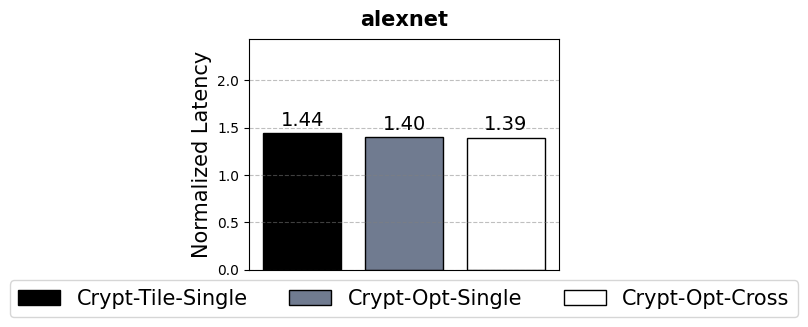

In [28]:
def plot_bar_graph(ax, data, labels, show_legend, title, show_ylabel):
    x_locations = np.arange(len(data))

    # Set the width of each bar
    num_groups = data.shape[0]
    num_bars = data.shape[1]
    bar_width = 1.0 / (num_bars + 3)
    space_width = 0.05
    
    # Set the x-axis positions for each group
    x_positions = np.arange(num_groups)

    ax.set_prop_cycle('color', plt.cm.bone(np.linspace(0, 1, num_bars)))
    
    # Define the hatch patterns to use for each bar
    hatch_patterns = ['.', '/', '\\', 'x', '-', '+']

    # Plot each group of bars
    for i in range(num_bars):
        # Calculate the x-axis positions for each bar within each group
        x_pos = x_positions + i * (bar_width + space_width)
        rects = ax.bar(x_pos, data[:, i], width=bar_width, align='edge', label=labels[i], edgecolor='black')

        # Add value of each bar as text
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points", ha='center', va='bottom', fontsize=14)

    # Remove the y-axis ticks
    ax.tick_params(axis='x', which='both', length=0, labelbottom=False)

    # Set the y-axis label
    if show_ylabel:
        ax.set_ylabel('Normalized Latency', fontsize=15)
    
    ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.5)
    
    # Set the ylim
    max_val = data.max() + max((data.max() - data.min()) * 0.4, 1)
    ax.set_ylim(0, max_val)

    if show_legend:
        ax.legend(ncol=3, loc='lower center', fontsize=15, bbox_to_anchor=(0.5, -0.25))
        
    ax.set_title(title, fontsize=15, fontweight='bold', y=1.02)
    
fig, ax = plt.subplots(figsize=(4, 3))
plot_bar_graph(ax, np.asarray([float(cts_latency) / float(baseline_latency), \
                               float(cos_latency) / float(baseline_latency), \
                               float(coc_latency) / float(baseline_latency)]).reshape((1, 3)), \
               ['Crypt-Tile-Single', 'Crypt-Opt-Single', 'Crypt-Opt-Cross'], 
               True, workload, True)

/tmp/ipykernel_3212/340207992.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('bone', 4)


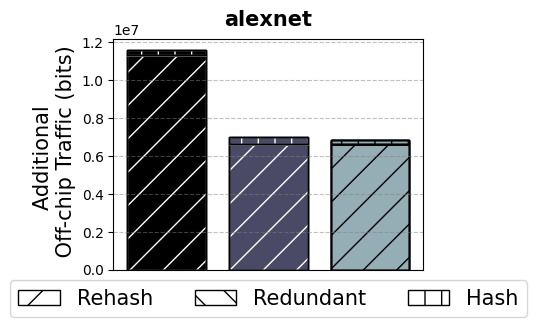

In [30]:
def plot_stacked_bar_graph(ax, data, labels, show_legend, title, ylog, show_ylabel):
    # Define the x locations for each group of bars
    x_locations = np.arange(len(data))

    # Set the width of each bar
    num_groups = data[0].shape[0]
    num_bars = data[0].shape[1]
    bar_width = 1.0 / (num_bars + 3)
    space_width = 0.05
    
    # Set the x-axis positions for each group
    x_positions = np.arange(num_groups)
    
    hatches = ['/', '\\', '|']
    cmap = plt.cm.get_cmap('bone', 4)
    
    # Plot each group of bars
    for i in range(num_bars):
        # Calculate the x-axis positions for each bar within each group
        x_pos = x_positions + i * (bar_width + space_width)
        bottom = np.zeros(num_bars)
        for j in range(len(data)):
            data_ = data[j]
            
            edgecolor = 'white' if i < 2 else 'black'
            ax.bar(x_pos, data_[:, i], width=bar_width, align='edge', edgecolor=edgecolor, hatch=hatches[j], \
                   bottom=bottom, color=cmap(i))
            ax.bar(x_pos, data_[:, i], width=bar_width, align='edge', edgecolor='black', \
                   bottom=bottom, color='none')
            bottom += data_[:, i]

    # Remove the y-axis ticks
    ax.tick_params(axis='x', which='both', length=0, labelbottom=False)

    # Set the ylim
    ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.5)
    
    if ylog:
        ax.set_yscale('log')
        
    if show_ylabel:
        ax.set_ylabel('Additional \n Off-chip Traffic (bits)', fontsize=15)
        
    ax.set_title(title, fontsize=15, fontweight='bold', y=1.02)

    if show_legend:
        # Add the legend
        legend_elements = [plt.Rectangle((0, 0), 1, 1, facecolor='none', edgecolor='black', linewidth=1, hatch=hatches[i]) \
                           for i in range(len(data))]
        # legend_handles = [Patch(facecolor='white', edgecolor='white', hatch=hatches[i]) for i in range(len(hatches))]
        ax.legend(legend_elements, labels, \
                  ncol=3, bbox_to_anchor=(0.5, -0.25), loc='lower center', fontsize=15)
        
fig, ax = plt.subplots(figsize=(4, 3))
plot_stacked_bar_graph(ax, \
                       [np.asarray([cts_traffic[2], cos_traffic[2], coc_traffic[2]]).reshape((1, 3)), \
                        np.asarray([cts_traffic[0], cos_traffic[0], coc_traffic[0]]).reshape((1, 3)), \
                        np.asarray([cts_traffic[1], cos_traffic[1], coc_traffic[1]]).reshape((1, 3))], \
                        ['Rehash', 'Redundant', 'Hash'], True, workload, False, True)